In [5]:
import pandas as pd
import numpy as np

from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from PIL import Image

plt.style.use('ggplot')

# Outline
1. Take a look at the data
2. Extract text from images:
    - pytesseract
    - easyocr
    - keras_ocr
3. Run on a few examples and compare the results

In [6]:
annot = pd.read_parquet('../input/textocr-text-extraction-from-images-dataset/annot.parquet')
imgs = pd.read_parquet('../input/textocr-text-extraction-from-images-dataset/img.parquet')
img_fns = glob('../input/textocr-text-extraction-from-images-dataset/train_val_images/train_images/*')

# Plot Example Images

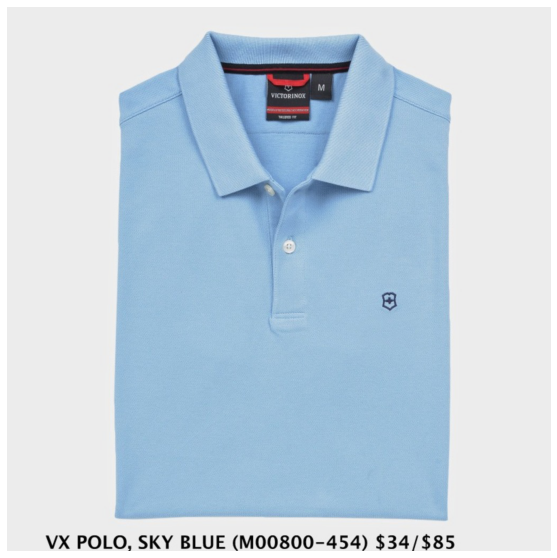

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(plt.imread(img_fns[20]))
ax.axis('off')
plt.show()

In [8]:
image_id = img_fns[20].split('/')[-1].split('.')[0]
annot.query('image_id == @image_id')

,id,image_id,bbox,utf8_string,points,area
167213,008d100b4f31c031_1,008d100b4f31c031,"[496.59, 160.42, 66.74, 12.87]",VICTORINOX,"[496.71, 160.42, 562.99, 160.65, 563.33, 173.2...",858.94
167214,008d100b4f31c031_2,008d100b4f31c031,"[584.52, 143.63, 15.0, 15.7]",M,"[584.62, 143.63, 599.42, 143.63, 599.52, 159.3...",235.50
167215,008d100b4f31c031_3,008d100b4f31c031,"[509.36, 203.7, 26.6, 7.7]",.,"[509.46, 203.8, 535.76, 203.7, 535.96, 211.2, ...",204.82
167216,008d100b4f31c031_4,008d100b4f31c031,"[536.06, 203.38, 10.1, 7.8]",.,"[536.06, 203.38, 546.16, 203.38, 546.16, 210.9...",78.78
167217,008d100b4f31c031_5,008d100b4f31c031,"[71.1, 992.23, 49.06, 29.73]",VX,"[71.1, 992.39, 120.16, 992.23, 120.16, 1021.63...",1458.55
167218,008d100b4f31c031_6,008d100b4f31c031,"[131.18, 992.21, 104.45, 31.68]","POLO,","[131.18, 992.37, 235.46, 992.21, 235.63, 1023....",3308.98
167219,008d100b4f31c031_7,008d100b4f31c031,"[246.36, 991.58, 67.09, 30.86]",SKY,"[246.36, 991.9, 313.45, 991.58, 313.29, 1021.7...",2070.40
167220,008d100b4f31c031_8,008d100b4f31c031,"[325.41, 991.68, 86.96, 30.22]",BLUE,"[325.41, 991.68, 412.18, 991.86, 412.37, 1021....",2627.93
167221,008d100b4f31c031_9,008d100b4f31c031,"[422.9, 989.8, 258.22, 33.94]",(M00800-454),"[423.18, 989.8, 680.27, 990.08, 681.12, 1023.7...",8763.99
167222,008d100b4f31c031_10,008d100b4f31c031,"[692.77, 989.52, 83.41, 34.33]",$34/,"[692.77, 989.89, 775.99, 989.52, 776.18, 1023....",2863.47


## Display for first 25 images

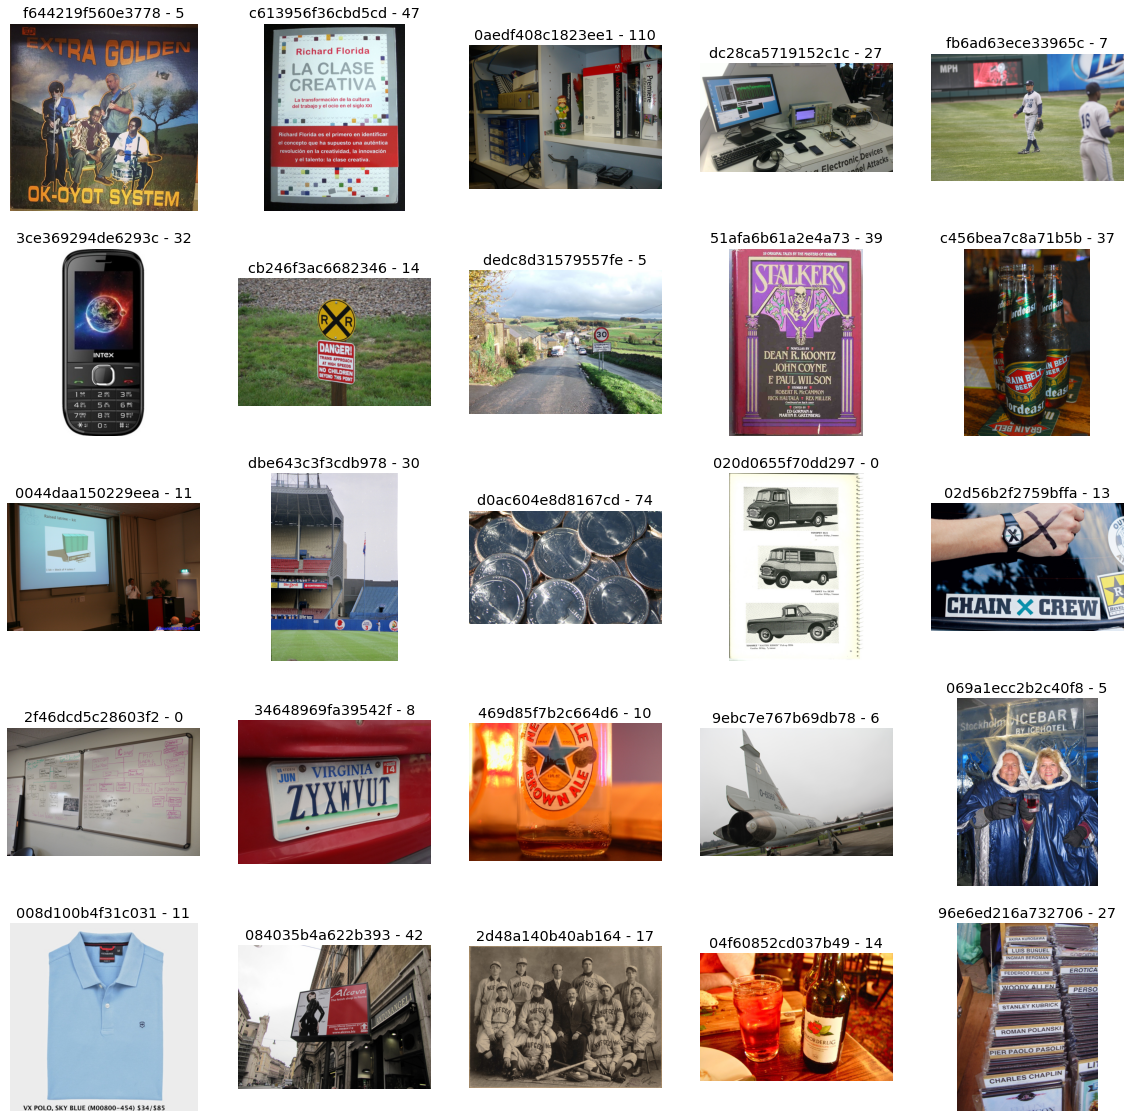

In [9]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
axs = axs.flatten()
for i in range(25):
    axs[i].imshow(plt.imread(img_fns[i]))
    axs[i].axis('off')
    image_id = img_fns[i].split('/')[-1].rstrip('.jpg')
    n_annot = len(annot.query('image_id == @image_id'))
    axs[i].set_title(f'{image_id} - {n_annot}')
plt.show()

# Method 1: pytesseract

In [10]:
import pytesseract

# Example call
print(pytesseract.image_to_string(img_fns[20], lang='eng'))

VX POLO, SKY BLUE (M00800-454) $34/$85



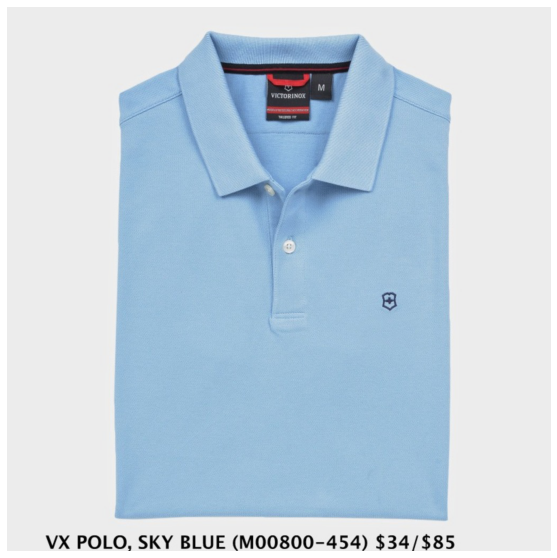

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(plt.imread(img_fns[20]))
ax.axis('off')
plt.show()

# Method 2: easyocr

In [12]:
import easyocr

reader = easyocr.Reader(['en'], gpu = True)

In [13]:
results = reader.readtext(img_fns[20])

In [14]:
pd.DataFrame(results, columns=['bbox','text','conf'])

,bbox,text,conf
0,"[[495, 159], [565, 159], [565, 175], [495, 175]]",VICTORINOX,0.705717
1,"[[71, 985], [849, 985], [849, 1024], [71, 1024]]","VX POLO,SKY BLUE (M00800-454) $34/585",0.542735


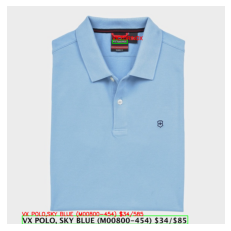

In [15]:
import matplotlib.pyplot as plt
import cv2

image_path = img_fns[20]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for (bbox, text, prob) in results:
    top_left = tuple(map(int, bbox[0]))
    bottom_right = tuple(map(int, bbox[2]))
    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
    cv2.putText(image, text, top_left, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

plt.imshow(image)
plt.axis('off')
plt.show()


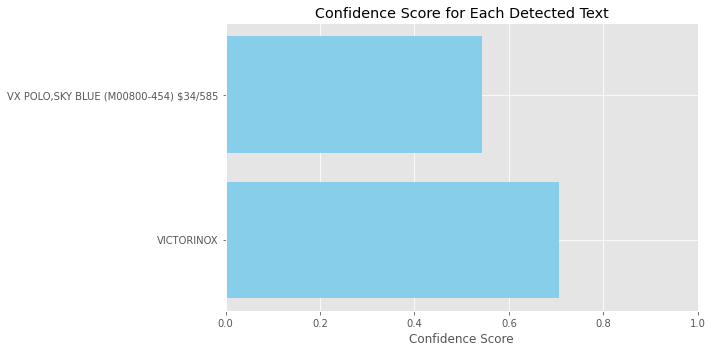

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Asumsikan `results` sudah tersedia
df = pd.DataFrame(results, columns=['bbox', 'text', 'conf'])

plt.figure(figsize=(10, 5))
plt.barh(df['text'], df['conf'], color='skyblue')
plt.xlabel('Confidence Score')
plt.title('Confidence Score for Each Detected Text')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


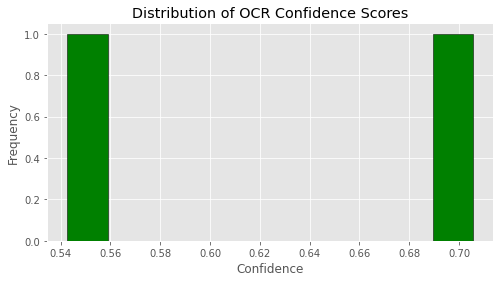

In [17]:
plt.figure(figsize=(8, 4))
plt.hist(df['conf'], bins=10, color='green', edgecolor='black')
plt.title('Distribution of OCR Confidence Scores')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


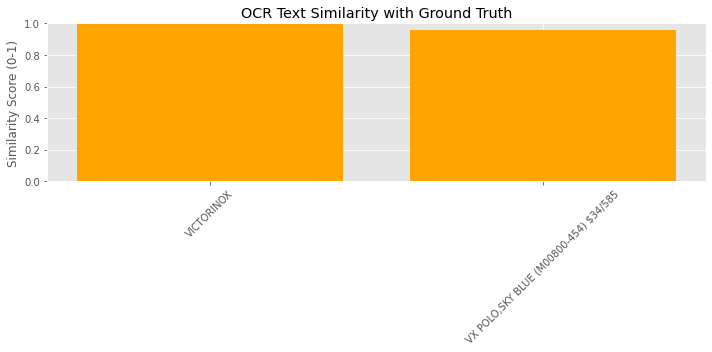

In [18]:
from difflib import SequenceMatcher

ground_truths = ["VICTORINOX", "VX POLO, SKY BLUE (M00800-454) $34/$85"]  # Contoh
df['ground_truth'] = ground_truths

# Hitung similarity
df['similarity'] = df.apply(lambda row: SequenceMatcher(None, row['text'], row['ground_truth']).ratio(), axis=1)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(df['text'], df['similarity'], color='orange')
plt.title('OCR Text Similarity with Ground Truth')
plt.ylabel('Similarity Score (0-1)')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [19]:
import easyocr
reader = easyocr.Reader(['en'], gpu=True)

results = []
for i in range(25):
    image_path = img_fns[i]
    ocr_result = reader.readtext(image_path)
    for bbox, text, conf in ocr_result:
        results.append({
            'image': image_path.split('/')[-1],
            'text': text,
            'conf': conf
        })

import pandas as pd
df = pd.DataFrame(results)
df.head()

plt.show()


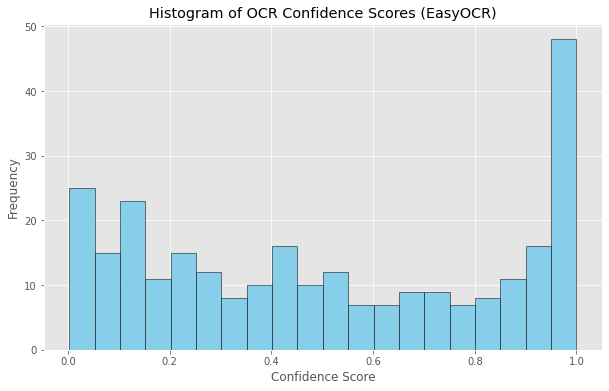

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df['conf'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of OCR Confidence Scores (EasyOCR)')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# Method 3: keras_ocr

In [22]:
!pip install keras-ocr -q

^C


In [23]:
import keras_ocr

pipeline = keras_ocr.pipeline.Pipeline()

ModuleNotFoundError: No module named 'keras_ocr'

In [ ]:
results = pipeline.recognize([img_fns[11]])

In [ ]:
pd.DataFrame(results[0], columns=['text', 'bbox'])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
keras_ocr.tools.drawAnnotations(plt.imread(img_fns[11]), results[0], ax=ax)
ax.set_title('Keras OCR Result Example')
plt.show()

# Compare easyocr vs. keras_ocr

In [ ]:
# easyocr
reader = easyocr.Reader(['en'], gpu = True)

dfs = []
for img in tqdm(img_fns[:25]):
    result = reader.readtext(img)
    img_id = img.split('/')[-1].split('.')[0]
    img_df = pd.DataFrame(result, columns=['bbox','text','conf'])
    img_df['img_id'] = img_id
    dfs.append(img_df)
easyocr_df = pd.concat(dfs)

In [ ]:
# keras_ocr
pipeline = keras_ocr.pipeline.Pipeline()

dfs = []
for img in tqdm(img_fns[:25]):
    results = pipeline.recognize([img])
    result = results[0]
    img_id = img.split('/')[-1].split('.')[0]
    img_df = pd.DataFrame(result, columns=['text', 'bbox'])
    img_df['img_id'] = img_id
    dfs.append(img_df)
kerasocr_df = pd.concat(dfs)

# Plot Results: easyocr vs keras_ocr

In [ ]:
def plot_compare(img_fn, easyocr_df, kerasocr_df):
    img_id = img_fn.split('/')[-1].split('.')[0]
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))

    easy_results = easyocr_df.query('img_id == @img_id')[['text','bbox']].values.tolist()
    easy_results = [(x[0], np.array(x[1])) for x in easy_results]
    keras_ocr.tools.drawAnnotations(plt.imread(img_fn), 
                                    easy_results, ax=axs[0])
    axs[0].set_title('easyocr results', fontsize=24)

    keras_results = kerasocr_df.query('img_id == @img_id')[['text','bbox']].values.tolist()
    keras_results = [(x[0], np.array(x[1])) for x in keras_results]
    keras_ocr.tools.drawAnnotations(plt.imread(img_fn), 
                                    keras_results, ax=axs[1])
    axs[1].set_title('keras_ocr results', fontsize=24)
    plt.show()

In [ ]:
# Loop over results
for img_fn in img_fns[:25]:
    plot_compare(img_fn, easyocr_df, kerasocr_df)

# The End